In [1]:
import pandas as pd
from operator import attrgetter
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from scipy.stats import ttest_ind, mannwhitneyu
import statistics
from scipy.stats import levene
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as ss
import requests
from urllib.parse import urlencode

In [2]:
groups_url= 'https://disk.yandex.ru/d/ikDG0MCAKjGFBg'
groups_add_url =  'https://disk.yandex.ru/d/tzsY5SFQK7zgLQ'
active_studs_url = 'https://disk.yandex.ru/d/BwX_z0xhTkJFSg'
checks_url = 'https://disk.yandex.ru/d/rPdOuisNRQoI5Q'

In [3]:
def ydisk(public_key: str) -> str:
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

In [4]:
groups = pd.read_csv(ydisk(groups_url), sep=';')# Информация о группах
group_add = pd.read_csv(ydisk(groups_add_url)) # Дополнительная информация о группах
active_studs = pd.read_csv(ydisk(active_studs_url)) # Активные пользователи
checks = pd.read_csv(ydisk(checks_url), sep=';')# Информация об оплатах

In [5]:
checks=checks.rename(columns=({'student_id':'id','rev':'revenue'}))
checks

,id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [6]:
# Переименововаю колонку и добавляю флаг на активных пользователей
active_studs = active_studs.rename(columns=({'student_id':'id'}))
active_studs['flag'] = 1
active_studs

,id,flag
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1
...,...,...
8336,1794344,1
8337,296883,1
8338,3598448,1
8339,3610547,1


In [7]:
full_groups = pd.concat([groups, group_add], ignore_index=True)

In [8]:
group_active_studs = full_groups.merge(active_studs, on = ['id'], how = 'left')
group_active_studs

,id,grp,flag
0,1489,B,NaN
1,1627,A,1.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN


In [9]:
checks_group_active_studs=group_active_studs.merge(checks, on ='id', how = 'left').fillna(0)
checks_group_active_studs

,id,grp,flag,revenue
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74571,200247820,B,0.0,0.0
74572,201032527,B,0.0,0.0
74573,201067612,B,0.0,0.0
74574,201067653,B,0.0,0.0


In [10]:
checks_group_active_studs.query("flag == 0 & revenue > 0 & grp == 'B'")

,id,grp,flag,revenue
39,3185,B,0.0,690.0
121,25973,B,0.0,690.0
125,26280,B,0.0,690.0
223,100645,B,0.0,630.0
254,102534,B,0.0,580.0
...,...,...,...,...
72452,5291900,B,0.0,199.0
72753,5331842,B,0.0,290.0
73632,5486319,B,0.0,199.0
74049,5562806,B,0.0,398.0


In [11]:
df=checks_group_active_studs.query("flag == 1")


In [12]:
metric = df.groupby('grp',as_index=False).agg(count_user =('id','nunique'),total_revenue=('revenue','sum'))
metric

,grp,count_user,total_revenue
0,A,1538,72820.0000
1,B,6803,394974.0035


In [13]:
metric_new = checks_group_active_studs.query("flag == 1 and revenue > 0").groupby('grp')['id'].nunique()
metric_new = metric_new.to_frame().rename(columns= {'id':'paying_users'})
metric_new

,paying_users
grp,
A,78
B,314


In [14]:
metrics= metric.merge(metric_new, on = "grp")

# Считаю метрики
1 Средний чек - Средний чек помогает понять, сколько в среднем тратят клиенты 

2 Конверсия в платящего пользователя -
высокая конверсия в платящих говорит о том, что  продукт хорошо воспринимается
пользователями и они готовы платить.

3 ARPU  - объединяет в себе информацию о среднем чеке и конверсии в платящих. 
Он показывает, сколько в среднем приносит каждый пользователь, независимо от того, платит он или нет.

In [15]:
metrics ['ARPU']= metrics.total_revenue / metrics.count_user
metrics['average_check']= metrics.total_revenue / metrics.paying_users
metrics['paying_conversion'] =  metrics.paying_users / metrics.count_user
metrics

,grp,count_user,total_revenue,paying_users,ARPU,average_check,paying_conversion
0,A,1538,72820.0000,78,47.347204,933.589744,0.050715
1,B,6803,394974.0035,314,58.058798,1257.878992,0.046156


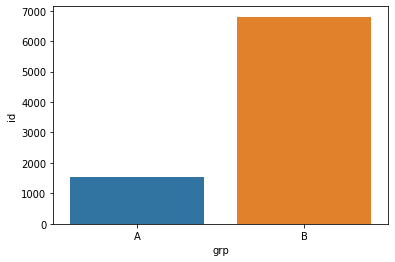

In [16]:
sns.barplot(data = df.groupby('grp', as_index = False).id.count()[['grp','id']], x = 'grp', y = 'id')

In [17]:
checks_group_active_stud_new = checks_group_active_studs.query("flag == 1")

In [18]:
# активные и платящие пользователи группа A
revenue_A = checks_group_active_stud_new[checks_group_active_stud_new['grp'] == 'A']

In [19]:
# активные и платящие пользователи группа B
revenue_B =checks_group_active_stud_new[checks_group_active_stud_new['grp'] == 'B']

In [21]:
gg =checks_group_active_stud_new[['grp','revenue']].set_index('grp')

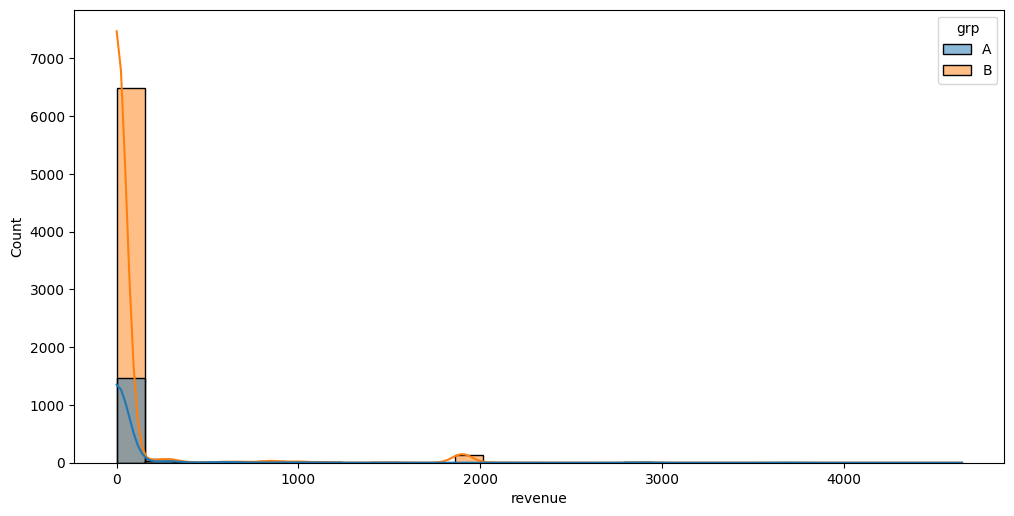

In [22]:
plt.figure(figsize=(12,6), dpi=100)
sns.histplot(data=gg, x='revenue', hue='grp', stat='count', bins=30, kde=True)

In [23]:

levene_stat, levene_pvalue = levene(revenue_A['revenue'], revenue_B['revenue'])
print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_pvalue}')
alpha = 0.05
if levene_pvalue < alpha:
    print("Существует значимая разница в дисперсиях выручки между группами A и B (Отвергаем нулевую гипотезу)")
else:
    print("Нет значимой разницы в дисперсиях выручки между группами A и B(Не можем отвергнуть нулевую гипотезу.)")

t-статистика: 1.501460829433639
p-значение: 0.22048133327049665
Нет значимой разницы в дисперсиях выручки между группами A и B(Не можем отвергнуть нулевую гипотезу.)


In [24]:
t_statistic, t_p_value = ttest_ind(revenue_A['revenue'], revenue_B['revenue'], equal_var=True)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {t_p_value}')
if t_p_value < alpha:
    print("Существует значимая разница в выручке между группами A и B (Отвергаем нулевую гипотезу)")
else:
    print("Нет значимой разницы в выручке между группами A и B(Не можем отвергнуть нулевую гипотезу.")

t-статистика: -1.2253411073793445
p-значение: 0.22048133326988378
Нет значимой разницы в выручки между группами A и B(Не можем отвергнуть нулевую гипотезу.


In [25]:
levene_stat, levene_pvalue = levene(revenue_A.query("revenue > 0")['revenue'], revenue_B.query("revenue > 0")['revenue'])
print(f't-статистика: {levene_stat}')
print(f'p-значение: {levene_pvalue}')
alpha = 0.05
if levene_pvalue < alpha:
    print("Существует значимая разница в дисперсиях выручки между группами A и B (Отвергаем нулевую гипотезу)")
else:
    print("Нет значимой разницы в дисперсиях выручки между группами A и B(Не можем отвергнуть нулевую гипотезу.)")

t-статистика: 3.075681699981606
p-значение: 0.08025675761347022
Нет значимой разницы в дисперсиях выручки между группами A и B(Не можем отвергнуть нулевую гипотезу.)


In [26]:
t_statistic, t_p_value = ttest_ind(revenue_A.query("revenue > 0")['revenue'], revenue_B.query("revenue > 0")['revenue'], equal_var=True)

print(f't-статистика: {t_statistic}')
print(f'p-значение: {t_p_value}')
if t_p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует значимая разница в выручке между группами A и B.")
else:
    print("Не можем отвергнуть нулевую гипотезу. Нет значимой разницы в выручке между группами A и B.")

t-статистика: -3.1337795050930985
p-значение: 0.0018562025265765867
Отвергаем нулевую гипотезу. Существует значимая разница в выручке между группами A и B.


In [27]:
cr1 = metrics[metrics['grp'] == 'A']['paying_users'] # Конверсия группы A
cr2 = metrics[metrics['grp'] == 'B']['paying_users'] # Конверсия группы B
n1 = metrics[metrics['grp'] == 'A']['count_user']  # Размер группы A
n2 = metrics[metrics['grp'] == 'B']['count_user']  # Размер группы B

stat, p_value = proportions_ztest([cr1, cr2], [n1, n2])

print(f"z-статистика: {stat}")
print(f"p-значение: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Существует значимая разница в конверсиях в оплату между группами A и B(Отвергаем нулевую гипотезу) ")
else:
    print("Нет значимой разницы в конверсиях в оплату между группами A и B(Не можем отвергнуть нулевую гипотезу)")

z-статистика: [0.76298845]
p-значение: [0.44547028]
Нет значимой разницы в конверсиях в оплату между группами A и B(Не можем отвергнуть нулевую гипотезу)


# Вывод
Изменения механики оплаты статистически значимо повлияли только на одну метрику из трёх — на средний чек, в то время как на CR и ARPU влияние не было статистически значимым.

Конверсия в оплату: Новая механика не оказала существенного влияния на конверсию в оплату. Более того, наблюдается незначительное снижение этого показателя. Однако это снижение не является критичным и может быть связано с временным эффектом адаптации пользователей к процессу оплаты.

Средний чек: Несмотря на небольшое снижение конверсии, новая механика оплаты повлияла на средний чек и выручку.

Рекомендации по внедрению новой механики оплаты.

Стоит ли вводить новую механику оплаты или нет, зависит от стратегических целей бизнеса и приоритетов.

Если цель — увеличение среднего чека: Новая механика оплаты может быть рекомендована к внедрению, так как средний чек вырос в тестовой группе примерно на 300.

Если цель — повышение конверсии: В текущем виде новая механика не демонстрирует улучшений в этой метрике.

Новая механика оплаты показала смешанные результаты: незначительное снижение конверсии в сочетании со статистически значимым ростом среднего чека и выручки.
